In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
img_count = len(list(data_dir.glob('*/*.jpg')))
print(img_count)

3670


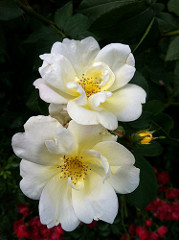

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


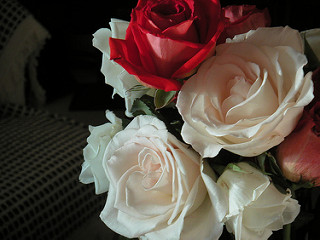

In [5]:
PIL.Image.open(str(roses[1]))

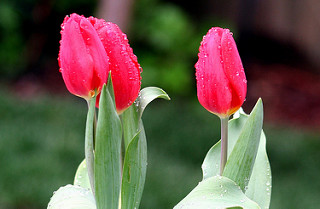

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

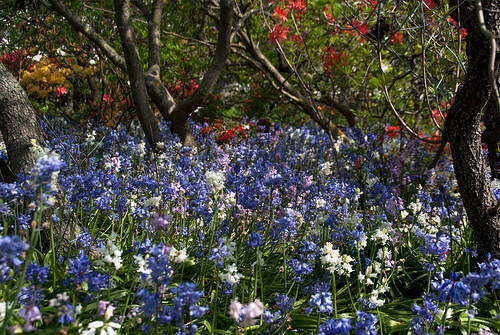

In [7]:
PIL.Image.open(str(tulips[1]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation",seed=123,image_size=(img_height,img_width), batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


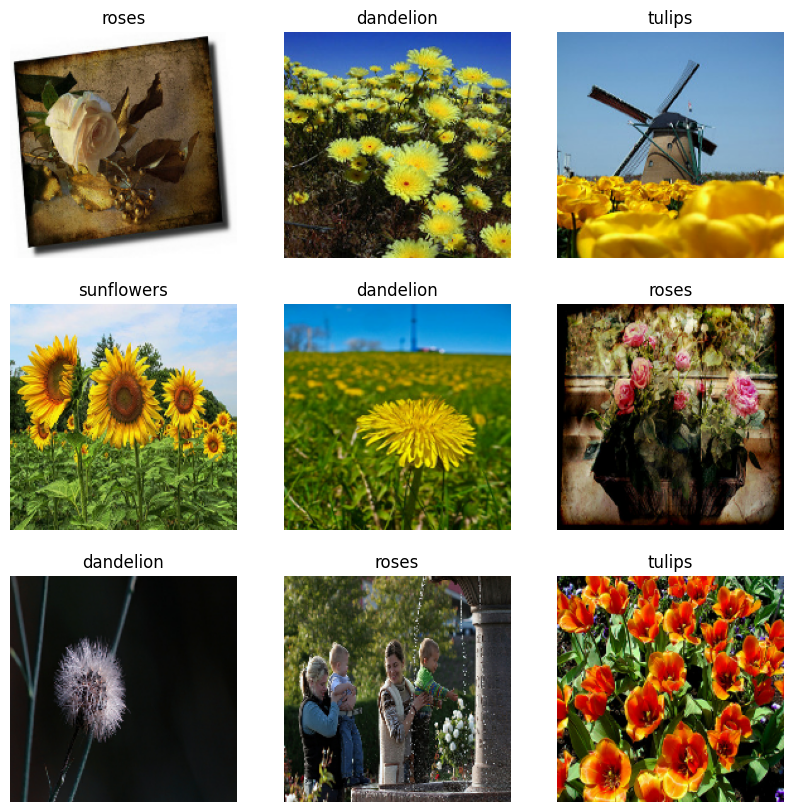

In [12]:
from matplotlib.pyplot import subplot


plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
hold_image = image_batch.numpy()
hold_label = labels_batch.numpy()
print(hold_image)
print(hold_label) 

(32, 180, 180, 3)
(32,)
[[[[8.83888855e+01 1.24388885e+02 2.00388885e+02]
   [8.89277802e+01 1.24927780e+02 2.00927780e+02]
   [8.88342590e+01 1.25369446e+02 1.99212967e+02]
   ...
   [2.14580017e+02 8.65392227e+01 2.93608099e-01]
   [2.33405533e+02 1.02674973e+02 5.17222071e+00]
   [2.28703690e+02 9.76851730e+01 2.50831127e+00]]

  [[9.02777786e+01 1.26277779e+02 2.02277786e+02]
   [9.08666611e+01 1.27150002e+02 2.03008331e+02]
   [9.50527802e+01 1.33036102e+02 2.06155548e+02]
   ...
   [1.61444641e+02 6.94110336e+01 9.16383362e+00]
   [1.72708313e+02 6.47249908e+01 1.37494326e+00]
   [1.53869415e+02 6.37055588e+01 4.15557909e+00]]

  [[9.30277786e+01 1.31027786e+02 2.06027786e+02]
   [9.27500000e+01 1.30819443e+02 2.05819443e+02]
   [9.83518524e+01 1.37162033e+02 2.09879623e+02]
   ...
   [1.18514069e+02 5.96759567e+01 8.26373959e+00]
   [1.67694916e+02 1.02569954e+02 4.29171982e+01]
   [2.26222305e+02 1.90916809e+02 1.68245605e+02]]

  ...

  [[8.00000458e+01 1.02430565e+02 3.508800

In [14]:
from tensorflow._api.v2.data import AUTOTUNE


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
#normalisation_layer = layers.Rescaling(1./255)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
#normalised_ds = train_ds.map(lambda x, y: (normalisation_layer(x), y))
#image_batch, labels_batch = next(iter(normalised_ds))
#first_image = image_batch[0]
#print(np.min(first_image), np.max(first_image))

In [17]:
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)

])

In [18]:
from tensorflow.python.training.saver import metrics


model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
epochs = 15
history = model.fit (train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 [==============================] - 45s 456ms/step - loss: 1.3256 - accuracy: 0.4196 - val_loss: 1.0967 - val_accuracy: 0.5545
Epoch 2/15
92/92 [==============================] - 41s 450ms/step - loss: 1.0017 - accuracy: 0.5960 - val_loss: 0.9978 - val_accuracy: 0.6076
Epoch 3/15
92/92 [==============================] - 43s 467ms/step - loss: 0.8263 - accuracy: 0.6849 - val_loss: 0.9531 - val_accuracy: 0.6090
Epoch 4/15
92/92 [==============================] - 47s 510ms/step - loss: 0.6308 - accuracy: 0.7738 - val_loss: 0.9764 - val_accuracy: 0.6431
Epoch 5/15
92/92 [==============================] - 48s 518ms/step - loss: 0.4400 - accuracy: 0.8416 - val_loss: 1.0080 - val_accuracy: 0.6417
Epoch 6/15
92/92 [==============================] - 43s 471ms/step - loss: 0.2608 - accuracy: 0.9169 - val_loss: 1.1637 - val_accuracy: 0.6294
Epoch 7/15
92/92 [==============================] - 49s 537ms/step - loss: 0.1719 - accuracy: 0.9448 - val_loss: 1.4434 - val_accuracy: 0.6267

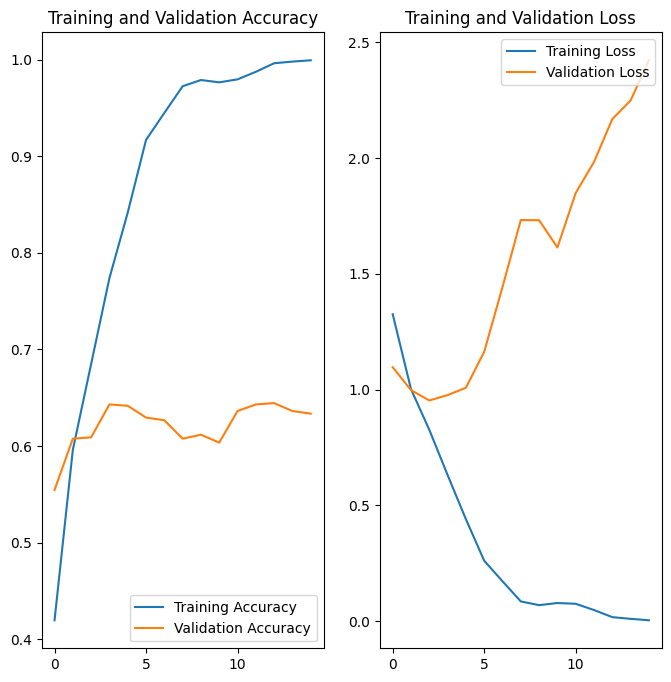

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

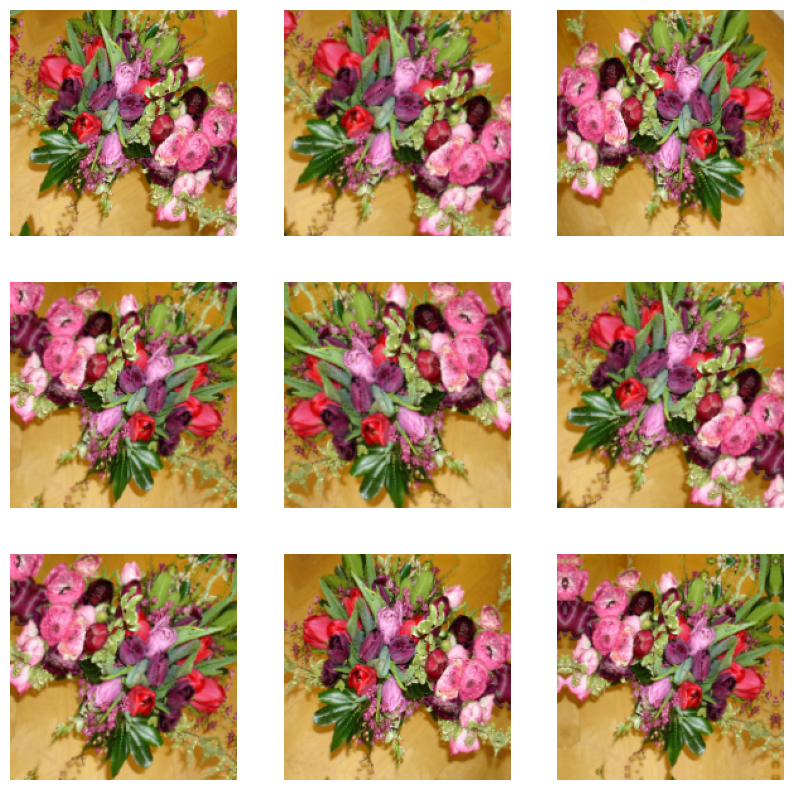

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 49s 522ms/step - loss: 1.3644 - accuracy: 0.4172 - val_loss: 1.1445 - val_accuracy: 0.5259
Epoch 2/15
92/92 [==============================] - 47s 508ms/step - loss: 1.0740 - accuracy: 0.5644 - val_loss: 1.0065 - val_accuracy: 0.6035
Epoch 3/15
92/92 [==============================] - 46s 504ms/step - loss: 0.9762 - accuracy: 0.6243 - val_loss: 1.0129 - val_accuracy: 0.5872
Epoch 4/15
92/92 [==============================] - 44s 478ms/step - loss: 0.8923 - accuracy: 0.6563 - val_loss: 0.9589 - val_accuracy: 0.6267
Epoch 5/15
92/92 [==============================] - 47s 511ms/step - loss: 0.8238 - accuracy: 0.6809 - val_loss: 0.9053 - val_accuracy: 0.6608
Epoch 6/15
92/92 [==============================] - 110s 510ms/step - loss: 0.7944 - accuracy: 0.6986 - val_loss: 0.9304 - val_accuracy: 0.6349
Epoch 7/15
92/92 [==============================] - 44s 481ms/step - loss: 0.7407 - accuracy: 0.7057 - val_loss: 0.7586 - val_accuracy: 0.697

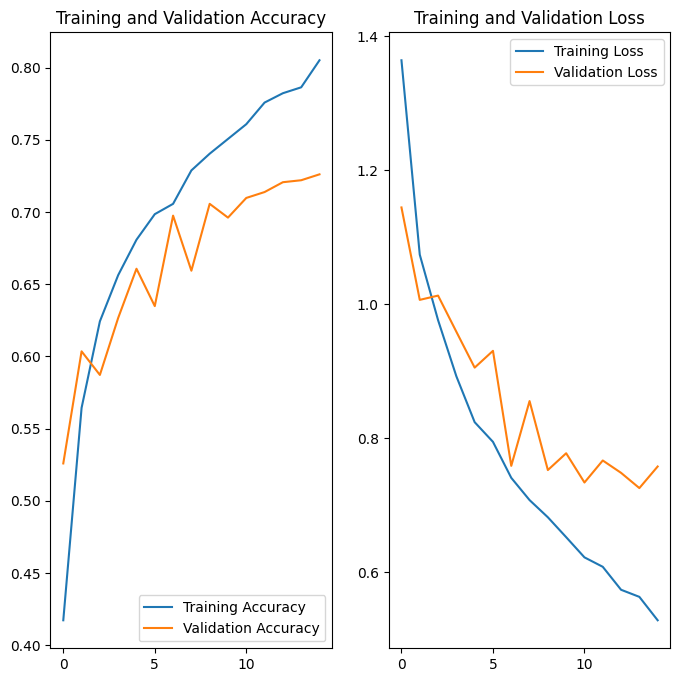

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 167ms/step
This image most likely belongs to sunflowers with a 92.27 percent confidence.


In [30]:
from pathlib import Path
output = Path.cwd() / "saved_models" / "Sequential"
model.save(output)

INFO:tensorflow:Assets written to: c:\Users\joshu\OneDrive\Documents\Uni\COMP4092\COMP4092_FAIMS_Thesis_MML\Project\Demo\saved_models\Sequential\assets


INFO:tensorflow:Assets written to: c:\Users\joshu\OneDrive\Documents\Uni\COMP4092\COMP4092_FAIMS_Thesis_MML\Project\Demo\saved_models\Sequential\assets


In [31]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model,  Path.cwd() / "saved_models" / "Sequential_layers")

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_seq_model = converter.convert()

with open('saved_models/tfLite_sequential.tflite', 'wb') as f:
    f.write(tflite_seq_model)

INFO:tensorflow:Assets written to: C:\Users\joshu\AppData\Local\Temp\tmpgmjefdcb\assets


INFO:tensorflow:Assets written to: C:\Users\joshu\AppData\Local\Temp\tmpgmjefdcb\assets


In [33]:
TFLITE_MODEL_FILE_PATH = 'saved_models/tfLite_sequential.tflite'

model_interpreter = tf.lite.Interpreter(model_path= TFLITE_MODEL_FILE_PATH)

model_interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [34]:
tfLite_classify_test = model_interpreter.get_signature_runner('serving_default')
tfLite_classify_test

In [35]:
tfLite_predictions = tfLite_classify_test(sequential_1_input=img_array)['outputs']
tfLite_score = tf.nn.softmax(tfLite_predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(tfLite_score)],  100*np.max(tfLite_score))
)

print(np.max(np.abs(predictions - tfLite_predictions)))

This image most likely belongs to sunflowers with a 92.27 percent confidence.
9.536743e-07
